In [22]:
import pandas as pd
import numpy as np
import pickle 
import torch
from data.prepareData import prepareDataLoader_fromPkl
import matplotlib.pyplot as plt
from scripts.visualisation import plot_cpg_reconstruction, plot_activations_latSpace
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor

import copy

# Trial - add L1 regularisation term

In [12]:
################################ Early stopping allowed ################################

!python train_AE_l1reg.py --name l1_regularisation/latSize_25 \
                    --train_file chr22_overlap_train_methyl_array.pkl \
                    --val_file chr22_overlap_val_methyl_array.pkl \
                    --hidden_layer_encoder_topology 2000 500 \
                    --latentSize 25 \
                    --learning_rate 1e-04 \
                    --n_epochs 500 \
                    --patienceEarlyStopping 300

normalAE(
  (encoder): Sequential(
    (0): Linear(in_features=4671, out_features=2000, bias=True)
    (1): Dropout(p=0.3, inplace=False)
    (2): PReLU(num_parameters=1)
    (3): BatchNorm1d(2000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Linear(in_features=2000, out_features=500, bias=True)
    (5): Dropout(p=0.3, inplace=False)
    (6): PReLU(num_parameters=1)
    (7): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Linear(in_features=500, out_features=25, bias=True)
    (9): PReLU(num_parameters=1)
  )
  (decoder): Sequential(
    (0): Linear(in_features=25, out_features=500, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=500, out_features=2000, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=2000, out_features=4671, bias=True)
    (5): Sigmoid()
  )
)
		Logging to logs/l1_regularisation/latSize_25/checkpoint
cpu
Epoch: 1
Training Loss: 324577.752
Validation Los

# Check reconstruction quality

In [13]:
PATH_data = "data"
PATH_results = "logs"

train_tensor = prepareDataLoader_fromPkl(f"{PATH_data}/chr22_overlap_train_methyl_array.pkl", colName="Age").returnTensor_()

with open(os.path.join(PATH_data, "chr22_overlap_test_methyl_array.pkl"), "rb") as f: test_dataset = pickle.load(f) #
test_tensor = torch.tensor(test_dataset["beta"].values, dtype=torch.float32)

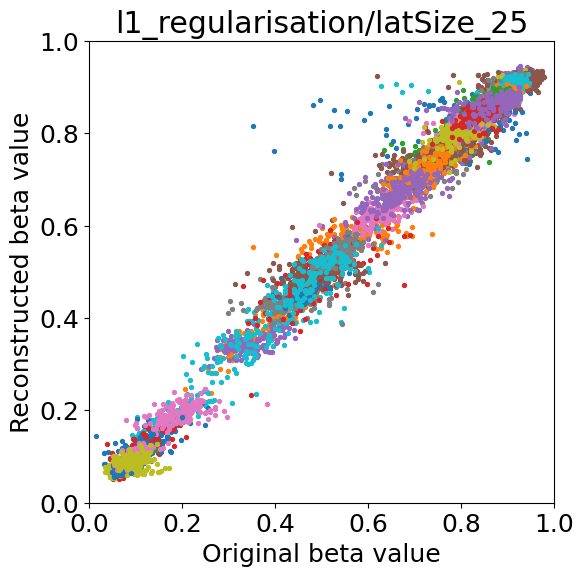

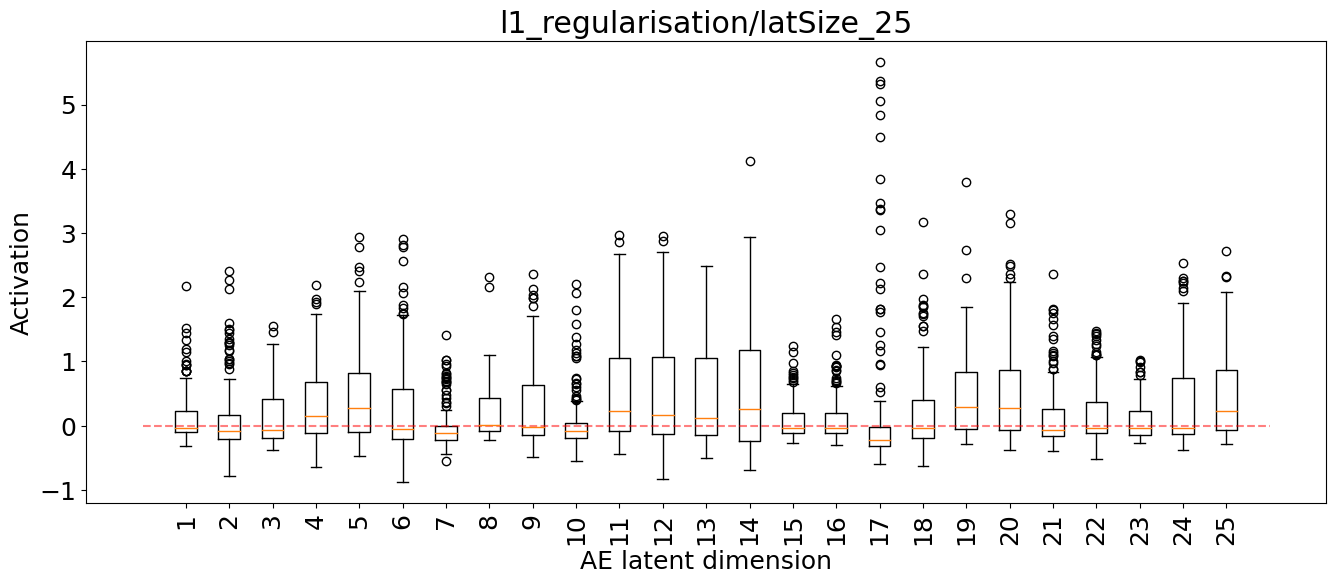

In [14]:
name = "l1_regularisation/latSize_25"
model = torch.load(f"logs/{name}/checkpoint/trainedModel.pth", map_location=torch.device('cpu'))

plot_cpg_reconstruction(model, test_tensor, title=name)
plot_activations_latSpace(model, test_tensor, title=name)

# Prediction from latent space

In [17]:
# Generate latent space
with torch.no_grad():
    latSpace_train = model.generate_embedding(train_tensor[0])
    latSpace_test = model.generate_embedding(test_tensor)    

## Remove samples with NA in target
# Train
y_train = train_tensor[1].detach().numpy()
mask_train = ~np.isnan(y_train)
latSpace_train = latSpace_train[mask_train]
y_train = y_train[mask_train]
# Test
y_test = test_dataset["pheno"]["Age"].values
mask_test = ~np.isnan(y_test)
latSpace_test = latSpace_test[mask_test]
y_test = y_test[mask_test]

# Train RFregression model
regr = RandomForestRegressor(random_state=0)
regr.fit(latSpace_train, y_train)
featureImportances = regr.feature_importances_

# Score on Test set
y_pred = regr.predict(latSpace_test)
r2 = regr.score(latSpace_test, y_test)

# save model
outPath = f"logs/{name}/regression/"
os.makedirs(outPath, exist_ok=True)
pickle.dump(regr, open(f"{outPath}/RFregressor.sav", 'wb'))

Text(0.5, 0, 'Feature')

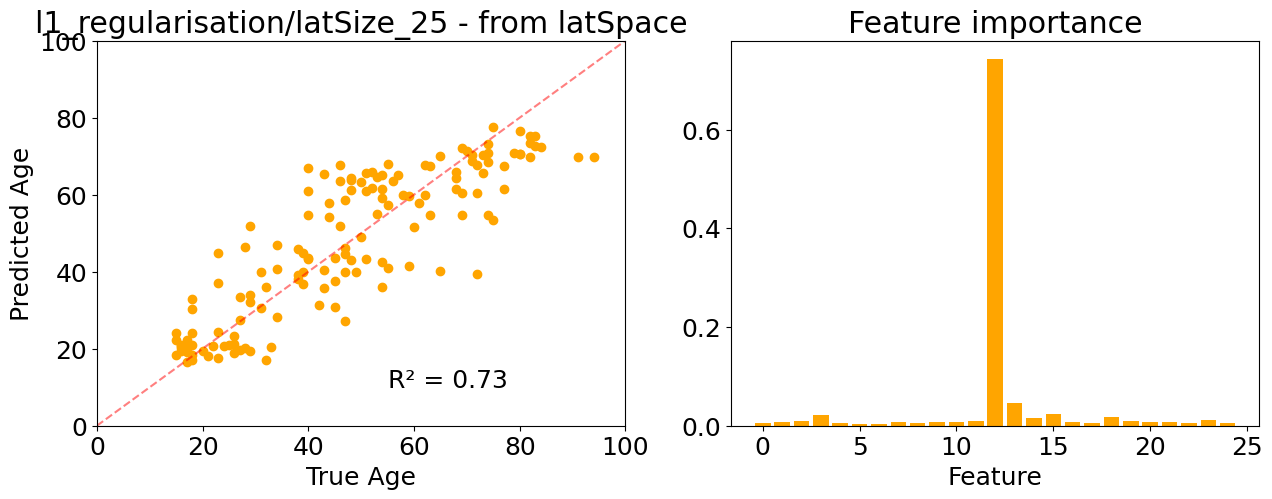

In [18]:
fig, (ax, ax2) = plt.subplots(1, 2,figsize=(15,5))
ax.scatter(y_test, y_pred, color="orange")
ax.plot([0, 1], [0, 1], transform=ax.transAxes, color="red", linestyle="dashed", alpha=0.5)
ax.text(55, 10, f"R² = {round(r2.mean(),2)}")
ax.set_xlim(0,100)
ax.set_ylim(0,100)
ax.set_title(f"{name} - from latSpace")
ax.set_xlabel("True Age")
ax.set_ylabel("Predicted Age")

ax2.bar(x=range(len(featureImportances)), height=featureImportances, color="orange")
ax2.set_title("Feature importance")
ax2.set_xlabel("Feature")

# Perturbations (vs no L1 penalty)

--> we expect less noise!

In [39]:
name = "l1_regularisation/latSize_25"
model = torch.load(f"logs/{name}/checkpoint/trainedModel.pth", map_location=torch.device('cpu'))

name2 = "optLatSize/latSize_25"
model2 = torch.load(f"logs/{name2}/checkpoint/trainedModel.pth", map_location=torch.device('cpu'))

In [40]:
with torch.no_grad():
    # generate latent space
    latSpace_np = model.generate_embedding(test_tensor).detach().numpy()

# Derive mean and std for perturbations
mean = latSpace_np.mean(axis=0)
std = latSpace_np.std(axis=0)
print(f"Perturb by: +-{std}")

############### NO REGULARISATION ####################

with torch.no_grad():
    # generate latent space
    latSpace_np2 = model2.generate_embedding(test_tensor).detach().numpy()

# Derive mean and std for perturbations
mean2 = latSpace_np2.mean(axis=0)
std2 = latSpace_np2.std(axis=0)
print(f"Perturb by: +-{std2}")

Perturb by: +-[0.4140573  0.5774007  0.4472935  0.60814065 0.7882456  0.73534477
 0.3501771  0.4049685  0.6242146  0.4737446  0.8037267  0.82082003
 0.8123557  0.89436996 0.30619487 0.38518733 1.314965   0.6470564
 0.65739465 0.78074545 0.52821875 0.46404716 0.30872446 0.73946273
 0.67476517]
Perturb by: +-[0.85225445 0.71795094 0.8080582  1.2799059  0.7498323  0.76417243
 0.60594344 0.68497807 0.4382189  0.8486009  1.1552653  0.4199526
 0.5073391  0.16094522 0.49599993 0.596132   0.4767665  0.75906104
 0.39282292 0.9267771  1.1007941  0.9893463  1.1694732  0.42574805
 0.44460618]


In [41]:
dic_pert = {}
for latvar in range(latSpace_np.shape[1]):
    dic_eachlat = {}
    for traversalVal in [std[latvar], std[latvar]*-1]: # perturb by adding / subtracting 1 std to every value
        with torch.no_grad():
            # generate latent space
            latSpace_orig = model.generate_embedding(test_tensor)
            # perturb
            latSpace_pert = copy.deepcopy(latSpace_orig)
            latSpace_pert[:,latvar] += traversalVal   

            # generate original & perturbed reconstructions
            recon_orig =  model.decode(latSpace_orig)
            recon_pert =  model.decode(latSpace_pert)

            # determine difference between orig & perturbed (median of all patients for each CpG)
            # potential point of improvement: some patients more affected than others?!
            dic_eachlat[str(round(traversalVal,2))] = np.median(abs(recon_orig - recon_pert).detach().numpy(), axis=0)
    dic_pert[latvar] = dic_eachlat

############### NO REGULARISATION ####################

dic_pert2 = {}
for latvar in range(latSpace_np2.shape[1]):
    dic_eachlat2 = {}
    for traversalVal in [std2[latvar], std2[latvar]*-1]: # perturb by adding / subtracting 1 std to every value
        with torch.no_grad():
            # generate latent space
            latSpace_orig = model2.generate_embedding(test_tensor)
            # perturb
            latSpace_pert = copy.deepcopy(latSpace_orig)
            latSpace_pert[:,latvar] += traversalVal   

            # generate original & perturbed reconstructions
            recon_orig =  model.decode(latSpace_orig)
            recon_pert =  model.decode(latSpace_pert)

            # determine difference between orig & perturbed (median of all patients for each CpG)
            # potential point of improvement: some patients more affected than others?!
            dic_eachlat2[str(round(traversalVal,2))] = np.median(abs(recon_orig - recon_pert).detach().numpy(), axis=0)
    dic_pert2[latvar] = dic_eachlat2

+3*STD: 0.0049034085823222995; (87,)
+2*STD: 0.0040074188727885485; (115,)
+1*STD: 0.0031114291632547975; (301,)
no effect; (4168,)


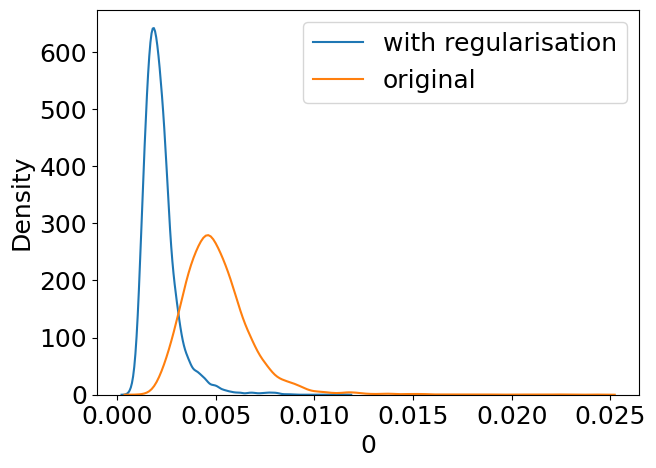

In [49]:
### Calculate median of traversals

df_allLat = pd.DataFrame()
for i in dic_pert.keys():
    df_allLat[i]=pd.DataFrame.from_dict(dic_pert[i]).median(axis=1)
# rename index to cpg names
df_allLat.index = test_dataset["beta"].columns

#####################

df_allLat2 = pd.DataFrame()
for i in dic_pert2.keys():
    df_allLat2[i]=pd.DataFrame.from_dict(dic_pert2[i]).median(axis=1)
# rename index to cpg names
df_allLat2.index = test_dataset["beta"].columns


# latFeature_i = 0
# fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,7))
# sns.kdeplot(data=df_allLat.iloc[:,latFeature_i], ax=ax1)
# sns.boxplot(data=df_allLat.iloc[:,latFeature_i], ax=ax2)
# ax1.set_title(f"Latent Feature: {latFeature_i} - perturbations across all CpGs")
# ax2.set_title(f"Latent Feature: {latFeature_i} - perturbations across all CpGs")

#########################################
#### Cutoff using Standard deviation ####
#########################################

latFeature_i = 0

mean = df_allLat.iloc[:,latFeature_i].mean()
std = df_allLat.iloc[:,latFeature_i].std()

thresh_high = mean+3*std
cpgs_high = df_allLat.iloc[:,latFeature_i][df_allLat.iloc[:,latFeature_i] > thresh_high]
print(f"+3*STD: {thresh_high}; {cpgs_high.shape}")

thresh_medium = mean+2*std
cpgs_medium = df_allLat.iloc[:,latFeature_i][(df_allLat.iloc[:,latFeature_i] > thresh_medium) & (df_allLat.iloc[:,latFeature_i] < thresh_high)]
print(f"+2*STD: {thresh_medium}; {cpgs_medium.shape}")

thresh_low = mean+1*std
cpgs_low = df_allLat.iloc[:,latFeature_i][(df_allLat.iloc[:,latFeature_i] > thresh_low) & (df_allLat.iloc[:,latFeature_i] < thresh_medium)]
print(f"+1*STD: {thresh_low}; {cpgs_low.shape}")

cpgs_none = df_allLat.iloc[:,latFeature_i][df_allLat.iloc[:,latFeature_i] < thresh_low]
print(f"no effect; {cpgs_none.shape}")


fig, ax1 = plt.subplots(1,1, figsize=(7,5))
sns.kdeplot(data=df_allLat.iloc[:,latFeature_i], ax=ax1, label="with regularisation")
sns.kdeplot(data=df_allLat2.iloc[:,latFeature_i], ax=ax1, label="original")

#
# #ax1.vlines(x=thresh_high, ymin=0, ymax=290, color="black", lw=2, linestyles="dashed", label="high")
# ax1.axvspan(thresh_high, df_allLat.iloc[:,latFeature_i].max() ,facecolor='black', alpha=0.25, label="high; 3*STD")
# #
# #ax1.vlines(x=thresh_medium, ymin=0, ymax=290, color="red", lw=2, linestyles="dashed", label="medium")
# ax1.axvspan(thresh_medium, thresh_high ,facecolor='red', alpha=0.25, label="medium; 2*STD")
# #
# #ax1.vlines(x=thresh_low, ymin=0, ymax=290, color="green", lw=2, linestyles="dashed", label="low")
# ax1.axvspan(thresh_low, thresh_medium ,facecolor='green', alpha=0.25, label="low; 1*STD")
# #
# ax1.axvspan(0, thresh_low ,facecolor='blue', alpha=0.25, label="none")
#
ax1.legend()
